In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/amazon-walmart-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','amazon-walmart-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in data.keys():
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/amazon-walmart-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/amazon-walmart-reduced/glove-300.matrix.npy',
                        text_columns = ['brand', 'groupname', 'title', 'shelfdescr',
                                        'shortdescr', 'longdescr'],
                        numeric_columns = [],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=[],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False,
                        embedding_trainable=True)

Number of inputs to dense layer: 6


# Train model 

In [112]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=2048,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 93243 samples, validate on 11656 samples
Epoch 1/1
93243/93243 [==============================] - 13s 142us/step - loss: 0.0022 - acc: 0.9993 - val_loss: 0.0092 - val_acc: 0.9980


# Learning curves

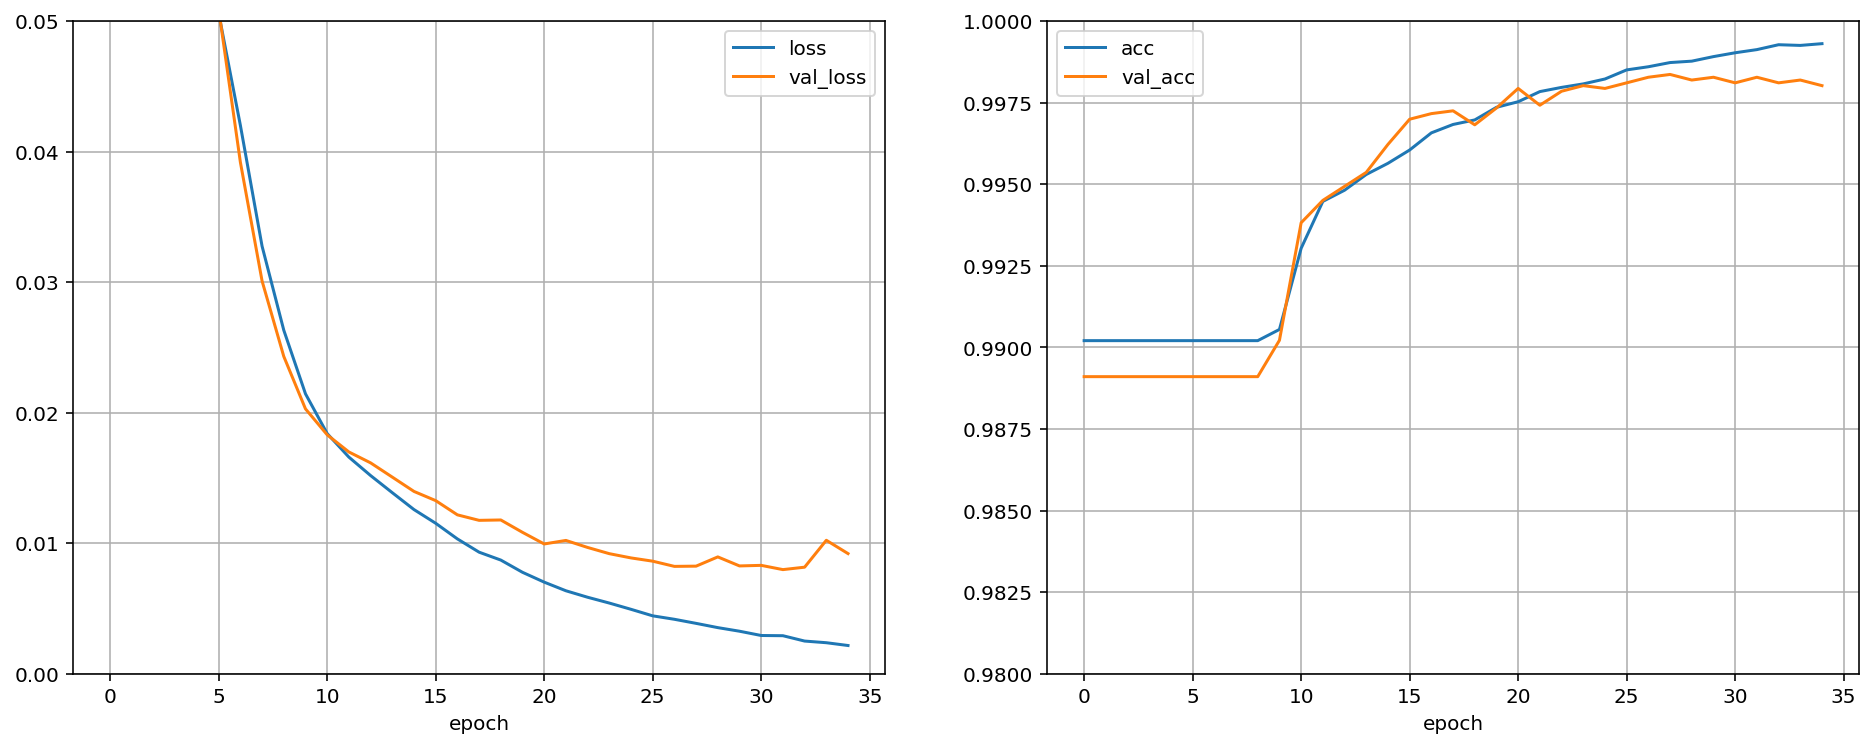

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.05)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(0.98, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [100]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11529
          1       0.91      0.93      0.92       127

avg / total       1.00      1.00      1.00     11656

[[11518    11]
 [    9   118]]


In [103]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['brand', 'groupname', 'title', 'shelfdescr',
           'shortdescr', 'longdescr']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,brand,groupname,title,price,shelfdescr,shortdescr,longdescr,shipweight,length,...,groupname,title,price,shelfdescr,shortdescr,longdescr,shipweight,length,width,height
4661,7325,usrobotics,networking products,usrobotics usr5637 56k usb faxmodem for windows mac linux,49.99,controller based dongle form factor,nan,us robotics robotics 5637 56k usb modem usr5637 modems,0.0,7.8,...,networking,usrobotics 56k usb external modem,47.82,delivers superb performance and reliability in compact flexible form factor,the usrobotics 56k usb modem delivers superb performance and reliability in compact flexible form,key features broadly compatible across major operating systems including linux windows and macintosh quick connect reduces your connection time to get you online quicker upstream provides 50 greater upload speeds and is ideal for sending messages with large attachments supports usrobotics modem on hold application to screen incoming voice calls while online answer calls without losing your internet connection no second phone line is needed,0.600,7.60,6.0,1.50
7026,13660,,desk supplies holders dispensers,notes dispenser inches inches black includes one original refill,10.99,made of strong neutral size inch includes one original refill neutral,what did you ever do without them notes dispensers makes it simple to grab one note at pick traditional style for the office trendy style for the home message center or mounted style for vertical dispensing having busy day and need to get more done there note for that the x3 size is perfect for writing reminder notes to work greener today for brighter tomorrow all notes are sfi chain of custody certified paper used comes from forests that are where trees are all notes are also recyclable so please remember to contains pack of original dispenser x3 in also try flag highlighters pens and markers available in variety of colors and,the note was invented as solution without in 1968 spencer silver 3m scientist developed unique repositionable as remarkable as it was the product could not find six years later colleague art fry recalled silver seminars promoting the light adhesive when he was daydreaming about bookmark that would stay put in his church the rest is today boasts more than 000 unique products and has become one of the most and beloved brands in the are all paper products recyclable 3m has conducted recycling trials on notes at recycled paper the adhesive does not interfere with paper recycling because the adhesive is substantially removed in the paper the dyes in the paper are also removed in this part of the are notes made from recycled paper many different colors and sizes of notes are available with paper containing at least 30 percent recycled in addition 3m offers 100 percent recycled content notes in canary yellow and assorted pastel the 100 percent recycled cont...,0.0,4.2,...,stationery office machinery,notes professional series dispenser for notes blk base,9.94,includes note pad in canary yellow stylish design weighted to prevent lifting,the notes professional series dispenser allows you to grab notes quickly and easily with one its practical design provides professional look and complements any office,notes professional series dispenser includes 50 sheet note pad in canary yellow black base weighted to prevent lifting,1.315,0.00,0.0,0.00
9062,17448,dymo,other office equipment,1754490 labelmanager 260p lines 10w 9d 5h dym1754490,0.00,nan,nan,eliminate the inconvenience of aa batteriesjust charge and go with this sleek label packed with new features inspired by labelmanager users to help you get the results you want with more ease and the large screen displays two lines of label plus the graphical display lets you see text effects onscreen before you works faster with an improved user interface that displays all menu options onscreen without scrolling and includes intuitive icons for formatting familiar offers quick access to special choose from three font styles six font sizes a

# Save model and histories 

In [104]:
pd.DataFrame(histories).to_csv('../data/histories/amazon-walmart-base-1t.csv', index=False)
model.save_weights('../data/models/amazon-walmart-base-1t')

# Test model 

In [105]:
y_test_pred = model.predict(X_test, batch_size=8192)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11541
          1       0.88      0.87      0.88       114

avg / total       1.00      1.00      1.00     11655

[[11528    13]
 [   15    99]]
